In [21]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

import keras

from evaluator import visualization as vis
from evaluator import defense
from evaluator.models.resnet import Resnet
from evaluator.models.model import CarliniCifarWrapper, RobustModel
from evaluator.dataset import CIFAR
from evaluator.utils import merge_and_generate_labels

%autoreload 2

## Setup model and load weights

In [115]:
data = CIFAR()
resnet = Resnet(data,bayesian=True)
model = resnet.model

In [116]:
path = "forks/nn_breaking_detection/models/cifar"
model.load_weights(path)

## Load some real and adversarial examples and plot them

(10000, 32, 32, 3)


(-0.5, 319.5, 31.5, -0.5)

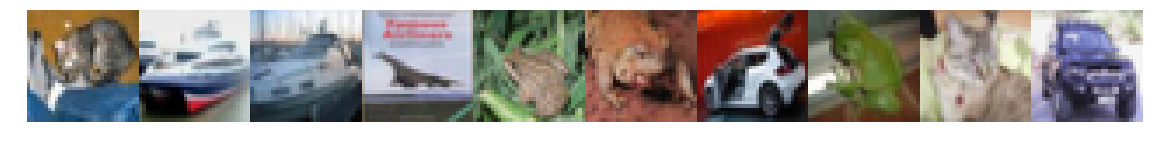

In [117]:
real = np.array(h5py.File('forks/nn_breaking_detection/adv_ex_10000.h5','r')['real'])
print(real.shape)
real_scaled = real - real.min()
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([real_scaled[i] for i in range(10)], axis=1))
plt.axis('off')

(10000, 32, 32, 3)


(-0.5, 319.5, 31.5, -0.5)

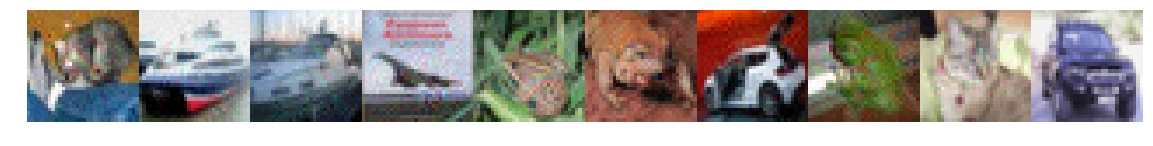

In [118]:
adv_johannes = np.array(h5py.File('forks/nn_breaking_detection/adv_ex_10000.h5','r')['adv'])
print(adv_johannes.shape)
adv_johannes_scaled = adv_johannes - adv_johannes.min()
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([adv_johannes_scaled[i] for i in range(10)], axis=1))
plt.axis('off')

(10000, 32, 32, 3)


(-0.5, 319.5, 31.5, -0.5)

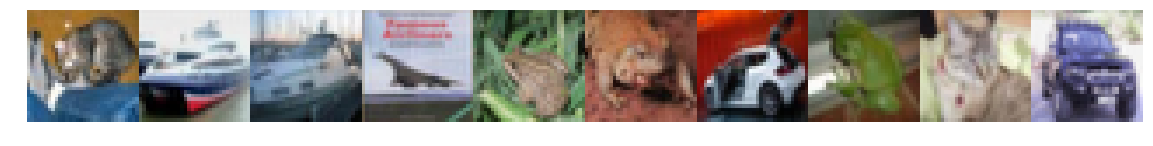

In [111]:
adv_rajanie = np.load('../LID_code/data/Adv_cifar_cw-l2_old.npy')
print(adv_rajanie.shape)
adv_rajanie_scaled = adv_rajanie - adv_rajanie.min()
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([adv_rajanie_scaled[i] for i in range(10)], axis = 1))
plt.axis('off')


(10000, 32, 32, 3)


(-0.5, 319.5, 31.5, -0.5)

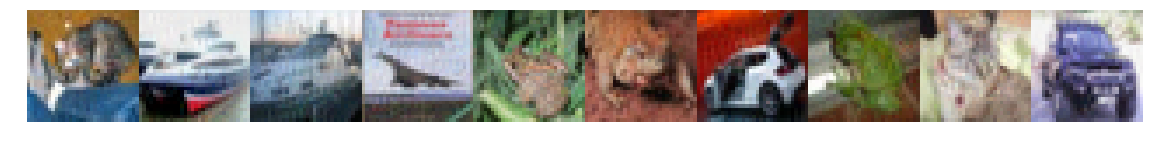

In [142]:
### adversarial examples created from LID code but using Johannes' parameters
adv_rajanie_newparameters = np.load('../LID_code/data/Adv_cifar_cw-l2.npy')
print(adv_rajanie_newparameters.shape)
adv_rajanie_scaled_newparameters = adv_rajanie_newparameters - adv_rajanie_newparameters.min()
plt.figure(figsize=(20,20))
plt.imshow(np.concatenate([adv_rajanie_scaled_newparameters[i] for i in range(10)], axis = 1))
plt.axis('off')


## How good is the model in detecting those?

In [121]:
N = 10000

adv = adv_johannes
guess = model.predict(adv[:N])
adv_johannes_dist = np.mean(np.sum((data.test_data[:N]-adv[:N])**2,axis=(1,2,3))**.5)
adv_johannes_acc = np.mean(np.argmax(guess,axis=1) == np.argmax(data.test_labels[:N],axis=1))

adv = adv_rajanie
guess = model.predict(adv[:N])
adv_rajanie_dist = np.mean(np.sum((data.test_data[:N]-adv[:N])**2,axis=(1,2,3))**.5)
adv_rajanie_acc = np.mean(np.argmax(guess,axis=1) == np.argmax(data.test_labels[:N],axis=1))

adv = adv_rajanie_newparameters
guess = model.predict(adv[:N])
adv_rajanie_newparameters_dist = np.mean(np.sum((data.test_data[:N]-adv[:N])**2,axis=(1,2,3))**.5)
adv_rajanie_newparameters_acc = np.mean(np.argmax(guess,axis=1) == np.argmax(data.test_labels[:N],axis=1))

print("Average distortion Rajanie's config: {}, Johannes' config:  {}".format(adv_rajanie_dist,adv_johannes_dist))
print("Average accuracy Rajanie's config: {}, Johannes' config:  {}".format(adv_rajanie_acc,adv_johannes_acc))
print("Rajanie's config newparameters Distance: {}, Accuracy: {}".format(adv_rajanie_newparameters_dist, adv_rajanie_newparameters_acc))

Average distortion Rajanie's config: 0.2610277150360239, Johannes' config:  1.2410388665096463
Average accuracy Rajanie's config: 0.9014, Johannes' config:  0.1398
Rajanie's config newparameters Distance: 1.1066345865535707, Accuracy: 0.7666


In [122]:
# What about the real rest set?!
guess = model.predict(real)
real_dist = np.mean(np.sum((data.test_data-real)**2,axis=(1,2,3))**.5)
real_acc = np.mean(np.argmax(guess,axis=1) == np.argmax(data.test_labels,axis=1))
print("Real distortion: {}; real acc: {}".format(real_dist,real_acc))

Real distortion: 0.0; real acc: 0.9174


# Is there a problem with Rajanie's adversarial examples? These should be really strong?

## Calculate some detection measures and visualize them

In [10]:
sess = keras.backend.get_session()
mi_defense = defense.MutualInformation(model,sess)
mi_rajanie = mi_defense(adv_rajanie, mc_passes=30)
mi_johannes = mi_defense(adv_johannes, mc_passes=30)

Predicted outputs with shape (10000, 30, 10) and 30 MC passes


/home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:73: Warning: negative values in mutual information, shape: (693,)
  "negative values in mutual information, shape: {}".format(negative_mi.shape), Warning)


Predicted outputs with shape (10000, 30, 10) and 30 MC passes


/home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:73: Warning: negative values in mutual information, shape: (250,)
  "negative values in mutual information, shape: {}".format(negative_mi.shape), Warning)


In [12]:
# calculate mi for real test images as well
mi_real = mi_defense(real, mc_passes=30)

Predicted outputs with shape (10000, 30, 10) and 30 MC passes


/home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:73: Warning: negative values in mutual information, shape: (674,)
  "negative values in mutual information, shape: {}".format(negative_mi.shape), Warning)


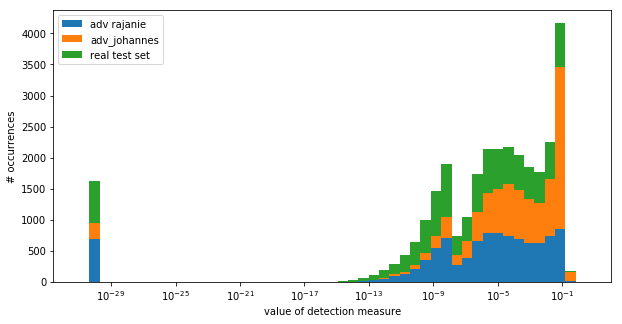

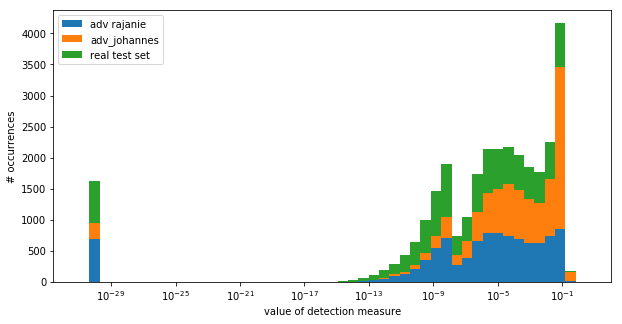

In [83]:
vis.histogram([mi_rajanie,mi_johannes,mi_real],['adv rajanie', 'adv_johannes','real test set'],stacked=True)

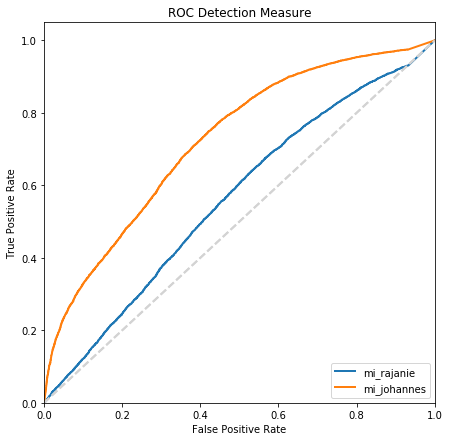

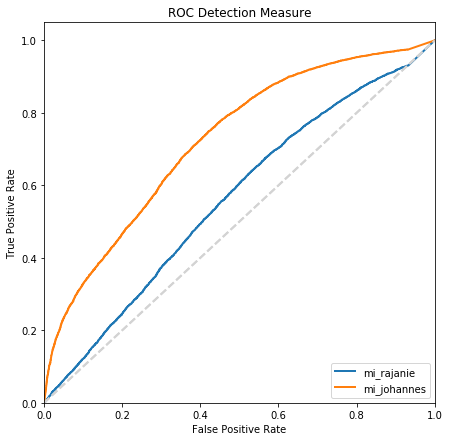

In [15]:
vis.roc([(mi_rajanie,mi_real),(mi_johannes,mi_real)],['mi_rajanie','mi_johannes'])

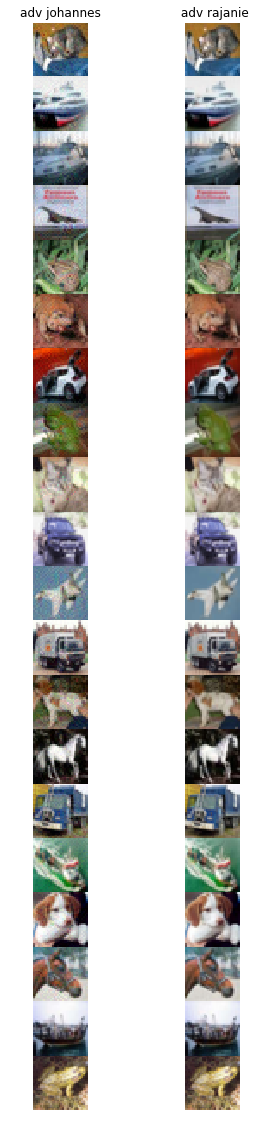

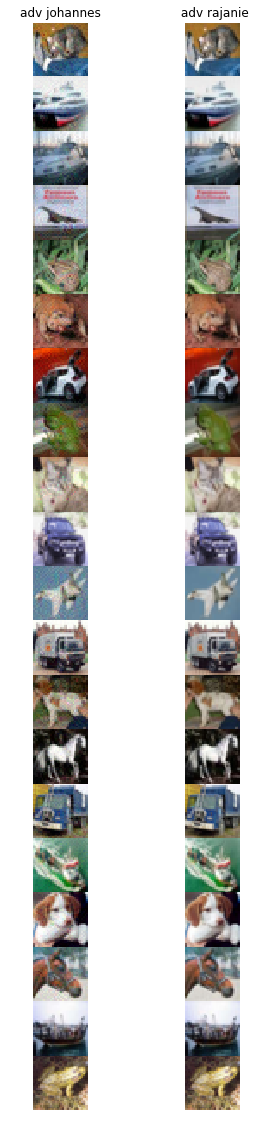

In [16]:
vis.images(adv_johannes[:20]+0.5,adv_rajanie[:20]+0.5,['adv johannes',' adv rajanie'])

In [31]:
### Testing LID

In [108]:
sess = keras.backend.get_session()
Lid = defense.LID(model,sess, real, adv_johannes, k= 20, batch_size = 100)
lids_normal, lids_adv = Lid.lid_scores()


Number of layers to estimate:  116


In [43]:
print(lids_normal)

(10000, 116)


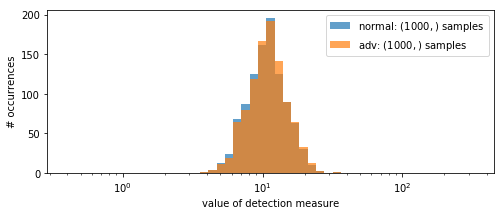

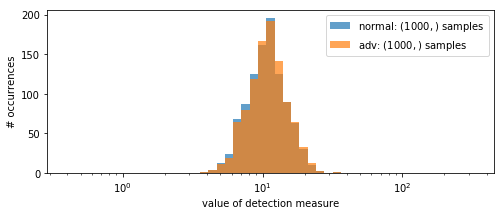

In [132]:
### LID on johannes' adversarial examples ### on first layer layer
vis.histogram([lids_normal[0:1000,0],lids_adv[0:1000,0]],['normal', 'adv'],stacked=False)

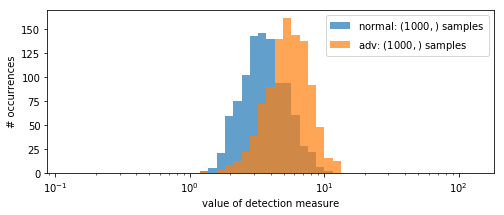

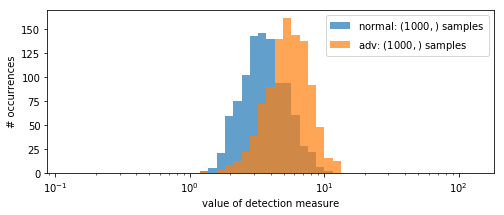

In [131]:
### LID on johannes' adversarial examples ### on last layer layer
vis.histogram([lids_normal[0:1000,115],lids_adv[0:1000,115]],['normal', 'adv'],stacked=False)

In [134]:
characteristics, label = merge_and_generate_labels(lids_normal,lids_adv)
data = np.concatenate((characteristics, label), axis=1)


X_pos:  (10000, 116)
X_neg:  (10000, 116)


Explained variation per principal component: [0.5042374  0.12576027 0.05141518]


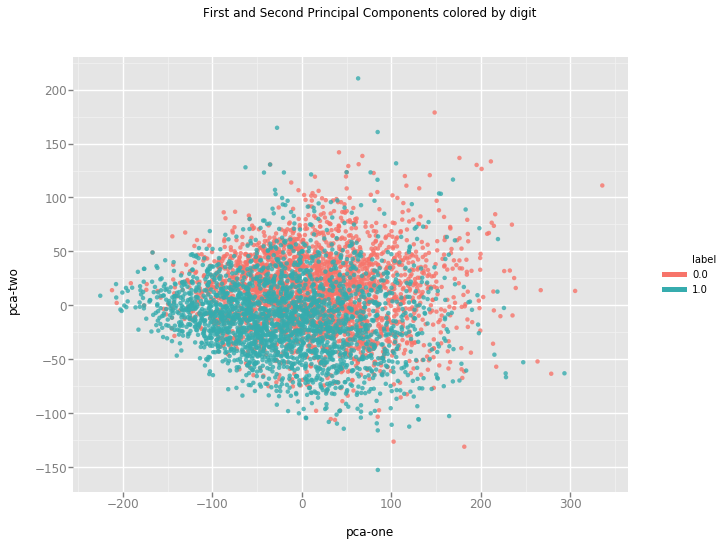

<ggplot: (-9223363253641139319)>

In [141]:
### Johannes' adversarial set
vis.PCAnalysis(characteristics,labels, 5000)  ### samples = 100